In [1]:
import numpy as np
from scipy.linalg import null_space
from scipy.linalg import ishermitian
from scipy.linalg import issymmetric
from scipy.linalg import eigh
from scipy.linalg import norm
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.linalg import eig
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from scipy.linalg import svd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
sns.set_theme()

import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score


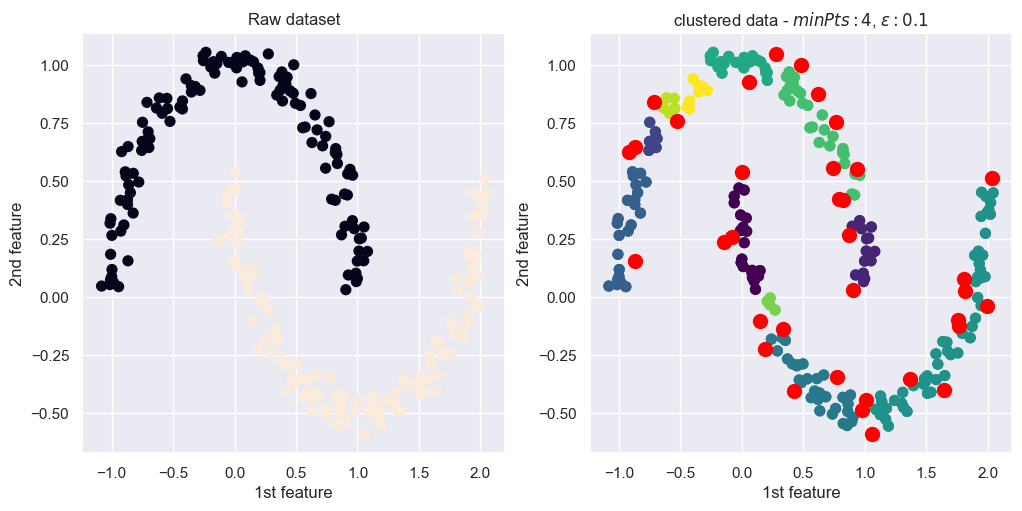

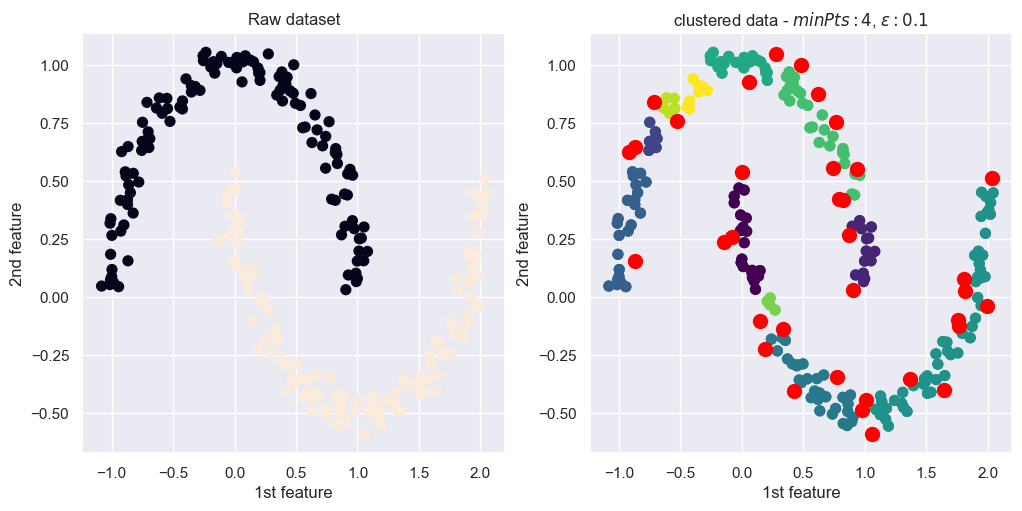

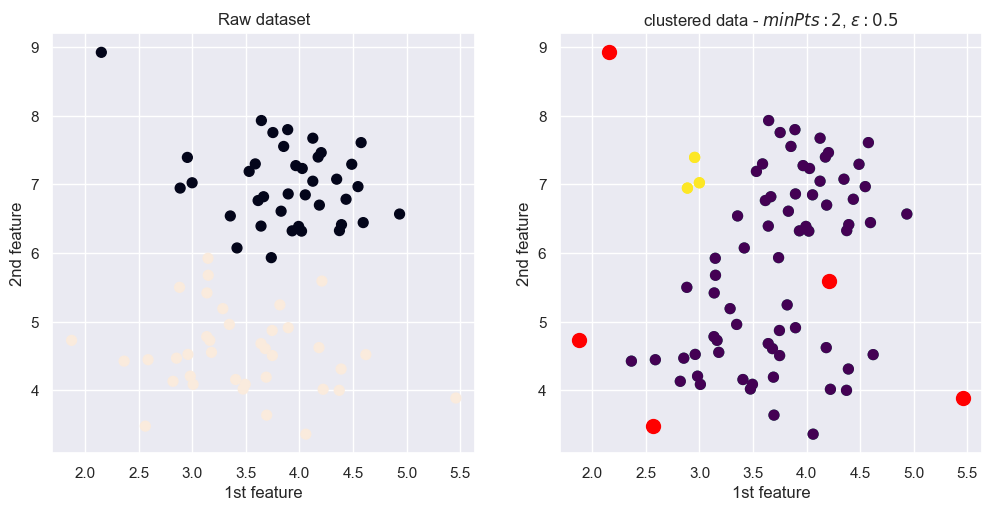

number of lambdas:  6


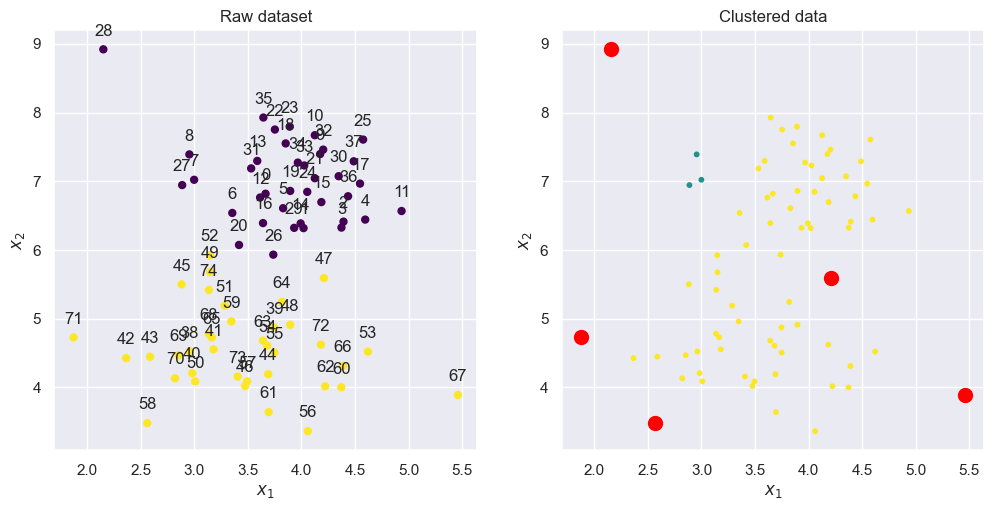

In [2]:
# running necessary functions
%run tree_plotting.ipynb
%run distance_metric.ipynb
%run density_tree.ipynb
%run DBSCAN.ipynb
%run SpectralClustering.ipynb

# Functions

In [3]:
def integrating_Fairness_Constraint(W, k, sensitive, laplacian = True):
    '''
    implementation of fair unnormalized SC with fairness constraints (algorithm 2) translated from MATLAB
    to Python
    
    github repo with original matlab code from paper: https://github.com/matthklein/fair_spectral_clustering/blob/master/Fair_SC_unnormalized.m
    
    # input: W weighted adjacency matrix (nxn), k number of clusters, sensitive encoding the sensitive attribute
    
    # output: H - eigenvectors drawn out of the subspace
    '''
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)

        # compute Laplacian from D and W (nxn)
        L = D-W
    else:
        L = W
    ######## COMPUTING L
    
    
    ######## COMPUTING F
    n = W.shape[0]
    sens_unique = np.unique(sensitive)
    h = len(sens_unique)
    sens_unique = np.reshape(sens_unique, [1,h])
    
    # sensitiveNew = sensitive.copy()  # should be npzeros
    sensitiveNEW = np.zeros(n)
    # print(n)
    
    temp = 0
    # print(len(sensitive))
    # print(len(sensitiveNEW))
    for i in range(h):
        for j in range(len(sensitive)):
            if sens_unique[0][i] == sensitive[j]:
                sensitiveNEW[j] = temp
        temp += 1
        
    # print(sensitiveNEW)
    
    # F - encodes group membership info from sensitiveNEW
    # normalize F so each 
    F = np.zeros((n, h-1)) # checkup with starting indices - F must be the issue
    for i in range(h-1):
        temp = (sensitiveNEW == i + 1)  # arrays start at 0, so need to add for boolean mask
        # print("temp: ", temp)
        F[temp, i] = 1
        groupSize = np.sum(temp)
        # print("gS \n", groupSize)
        F[:, i] = F[:, i] - (groupSize/n)  # operation that enforces balance constraint  # does it need to be i-1? 
    

    # the group membership vector sensitiveNEW - sensitivegroup/n multiplied with 1-vector
    
    
    # normalize
    F = F / np.linalg.norm(F, axis=0)
    # print(F)
    # print("normal \n", F)
    ########### COMPUTING F
    
    ########## COMPUTING Z
    
#     Z = null_space(F.T)
#     Z = Z / np.linalg.norm(Z, axis=0)  # normalized for orthonormal basis
    
    # computing with equivalency to MATLAB's null function
    U, S, V = svd(F.T)
    
    # checking dimensions and finding rank
    m, n = (F.T).shape
    rank = np.sum(S > np.finfo(float).eps * max(m, n))
    print("rank: ", rank)
    
    # extract columns of V that are singular values close to zero
    null_space = V[rank:].T
    
    # normalize columns of null_space
    null_space = null_space / np.linalg.norm(null_space, axis = 0)
    Z = null_space  # equivalency to scipy's norm function, no issue there
    
    
    ########### COMPUTING Z
    
    return Z
    

In [4]:
# https://arxiv.org/pdf/2004.05048.pdf - their ultrametric SC takes in the ultrametric, and runs the spectral clustering algorithm
# need to take first cut spectral clustering
def first_cut_spectral_clustering_EIG(W, k, laplacian = True, sim = False):
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)

        # compute Laplacian from D and W (mxn)
        L = D-W
    else:
        L = W
    ######## COMPUTING L
    
    print(L.shape)
    eigVals, eigVecs = np.linalg.eigh(L)  # can't do eigenvalue with non-square matrix
    # eigenvectors of Laplacian matrix can be obtained from the right singular vectors of the matrix obtained from the SVD (normalized L?)
    
    # matrix X from smallest eigenvectors
    if sim == True:  # similarity should ascending smallest instead of descending largest
        eigVecs = eigVecs[:, -k:] # ascending - SVD default is descending
    else:
        eigVecs = eigVecs[:, :k]  # descending
    X = eigVecs# <- works with mxn, but not compatible when plotting
    
    # normalize rows
    X = X / np.sqrt(np.sum(X**2, axis = 1, keepdims = True))
    print(X.shape)
    # Normalize the rows of the eigenvector matrix
    # row_norms = np.linalg.norm(eigVecs, axis=1)
    # eigVecs_norm = eigVecs / row_norms[:, np.newaxis]
    # X = eigVecs_norm
    
    # cluster rows via kmeans - also kmeans used in SpectralClustering.ipynb
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X)
    labels = kmeans.labels_
    
    return labels

In [127]:
def bera_balance(clustering_labels, sensitive_attr):
    
    if len(np.unique(clustering_labels)) == 1:
        return 0
    
    d = {'G' : sensitive_attr, 'C' : clustering_labels}
    df = pd.DataFrame(data=d)
    overall_count = df.groupby('G').size().to_frame()
    overall_count.columns = ['overall']
    # print(overall_count)
    
    indi_count = df.groupby(['G', 'C']).size().unstack()
    # indi_count.columns = ['c0', 'c1', 'c2']
    # print("indi_count before \n", indi_count)
    num_C = np.unique(clustering_labels)
    
    indi_count.columns = [f'c{i}' for i in range(len(num_C))]
    indi_count = indi_count.fillna(0)
    # print("indi_count \n", indi_count)
    result = overall_count.merge(indi_count, on='G')
    print("overall indi merged \n", result)
    
    result['r_overall'] = result['overall']/result['overall'].sum()
    # print("result \n", result)
    
    for col in indi_count.columns:
        name = 'r_' + col
        # print(name)
        result[name] = result[col]/result[col].sum()
    # print(result)
    df1 = result[['r_' + x for x in indi_count.columns]]
    # print(df1)
    balance = df1.div(result['r_overall'], axis = 0)
    balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
    # print("balance \n", balance)
    # print("balanec inv \n", balance_inverse)

    min_balance_dataframe = pd.DataFrame(np.minimum(balance.values, balance_inverse.values), columns=balance.columns, index=balance.index)
    # print(min_balance_dataframe)
    cluster_balances = min_balance_dataframe.min()
    print(cluster_balances)
    # min_balance = np.min(pd.concat([balance, balance_inverse]))
    min_balance = cluster_balances.min()
    
    # handle runtime warning or no?

    return min_balance

In [56]:
# imposing fairness constraint
def unnormalized_SC_With_Fairness_Constraints(W, k, sensitive, laplacian = True):
    '''
    implementation of fair unnormalized SC with fairness constraints (algorithm 2) translated from MATLAB
    to Python
    
    github repo with original matlab code from paper: https://github.com/matthklein/fair_spectral_clustering/blob/master/Fair_SC_unnormalized.m
    
    # input: W weighted adjacency matrix (nxn), k number of clusters, sensitive encoding the sensitive attribute
    
    # output: H - eigenvectors drawn out of the subspace
    '''
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)
        # print(D)

        # compute Laplacian from D and W (nxn)
        L = D-W
    else:
        L = W
    # print(L)
    ######## COMPUTING L

    
    
    ######## COMPUTING F
    n = W.shape[0]
    sens_unique = np.unique(sensitive)
    h = len(sens_unique)
    sens_unique = np.reshape(sens_unique, [1,h])
    
    # sensitiveNew = sensitive.copy()  # should be npzeros
    sensitiveNEW = np.zeros(n)
    # print(n)
    
    temp = 0
    # print(len(sensitive))
    # print(len(sensitiveNEW))
    for i in range(h):
        for j in range(len(sensitive)):
            if sens_unique[0][i] == sensitive[j]:
                sensitiveNEW[j] = temp
        temp += 1
        
    # print(sensitiveNEW)
    
    # F - encodes group membership info from sensitiveNEW
    # normalize F so each 
    F = np.zeros((n, h-1)) # checkup with starting indices - F must be the issue
    for i in range(h-1):
        temp = (sensitiveNEW == i + 1)  # arrays start at 0, so need to add for boolean mask
        # print("temp: ", temp)
        F[temp, i] = 1
        groupSize = np.sum(temp)
        # print("gS \n", groupSize)
        F[:, i] = F[:, i] - (groupSize/n)  # operation that enforces balance constraint  # does it need to be i-1? 
    

    # the group membership vector sensitiveNEW - sensitivegroup/n multiplied with 1-vector
    
    
    # normalize
    F = F / np.linalg.norm(F, axis=0)
    # print("normal \n", F)
    ########### COMPUTING F
    
    ########## COMPUTING Z
    
#     Z = null_space(F.T)
#     Z = Z / np.linalg.norm(Z, axis=0)  # normalized for orthonormal basis
    
    # computing with equivalency to MATLAB's null function
    U, S, V = svd(F.T)
    
    # checking dimensions and finding rank
    m, n = (F.T).shape
    rank = np.sum(S > np.finfo(float).eps * max(m, n))
    print("rank: ", rank)
    
    # extract columns of V that are singular values close to zero
    null_space = V[rank:].T
    
    # normalize columns of null_space
    null_space = null_space / np.linalg.norm(null_space, axis = 0)
    Z = null_space  # equivalency to scipy's norm function, no issue there
    
    
    
    ########### COMPUTING Z
    
    ########## COMPUTING eigenvectors and H
    print(Z.shape)
    print((L@Z).shape)
    print(L.shape)
    
    Z_lap = Z.T @ L @ Z
    Z_lap = (Z_lap + Z_lap.T)/2 # ensuring symmetry
    # print("symmetric?", np.array_equal(Z_lap, Z_lap.T))
    
    
    ########### COMPUTING eigenvectors and H
    # print("Z_lap \n", Z_lap[])
    # print(Z_lap[:10])
    
    ########## PERFORMING KMEANS

    
    # eigValues, Y = eig(Z_lap)
    # indices = eigValues.argsort()[:k]
    try:
        eigValues, Y = eigsh(Z_lap, k, which='SM', maxiter=1000, ncv=min(Z_lap.shape[0], max(2*k, 25)))
    except:
        eigValues, Y = eigsh(Z_lap, k, which='SA', maxiter=1000, tol = 0.01, ncv=min(Z_lap.shape[0], max(2*k, 25)))
    # eigValues, Y = eig(Z_lap)
    Y = Y[:, :k]
    # print(Y)
    
    # normalize rows or no?
    # norms = np.linalg.norm(Y, axis=1)
    # Y = Y / np.reshape(norms, (-1, 1))
    
    H = Z @ Y
    # print("\n H:  \n", H)
    
    ########### PERFORMING KMEANS
    
    ########### PERFORMING KMEANS
    
    
    ######### PERFORMING DBSCAN/KMEANS
    kmeans = KMeans(n_clusters=k, random_state=0).fit(H)
    labels = kmeans.labels_
    
    # dbscan = DBSCAN(eps = eps, min_pts = minPts, cluster_type = 'standard')
    # dbscan.fit(X)
    # labels = dbscan.labels_
    # print(y.shape)
    # dbscan.plot2D(y)
    
    return H, labels
    
    ########## DBSCAN
    

    
    # return pseudo
    

In [7]:
# Compute pairwise distances

def generate_adjacency_Gaussian(data_sensitive):
    distances = squareform(pdist(data_sensitive[:, :-1]))
    # Compute similarity matrix using Gaussian kernel
    sigma = 0.5  # parameter for Gaussian kernel

    similarity = np.exp(-distances ** 2 / (2 * sigma ** 2))
    # print(similarity[0])

    # Construct weighted adjacency matrix
    n = len(data_sensitive)
    adjacency = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            w = similarity[i, j]
            adjacency[i, j] = w
            adjacency[j, i] = w
    # print(adjacency.shape)
    return adjacency
# print(adjacency[0])

In [61]:
def balance_list_over_all_k(data, sensitive, number_of_k_for_range, adjacency_matrix, 
                            min_points = 5, n_neighbors = 10, eps = 0.5, min_pts = 5):
    vanillaSC_balance = []
    vanillaDBSCAN_balance = []
    fairSC_balance = []
    fairDC_dist_balance = []

    for k in list(range(2, number_of_k_for_range)):
        dsnenns = get_nearest_neighbors(data, k, min_points)
        dsnedist = np.reshape(dsnenns['_all_dists'], -1)
        dist_dsne = dsnenns['_all_dists']
        root_, dc_dist = make_tree(data, sensitive, min_points, n_neighbors)
        
        Z = integrating_Fairness_Constraint(dist_dsne, k, sensitive, laplacian = False)
        Z_pinv = np.linalg.pinv(Z)
        Z_dist_dsne = Z_pinv.T @ (Z.T @ dist_dsne @ Z) @ Z_pinv
        
        FairDC_dist_labels = first_cut_spectral_clustering_EIG(Z_dist_dsne, k, laplacian = False, sim = False)
    
        # vanilla spectral clustering
        # no_lambdas = get_lambdas(root_, eps)
        # sim = get_sim_mx(dist_dsne, in_dict = False)
        # SC_, vanillaSC_labels = run_spectral_clustering(root_, sim, dist_dsne, eps=eps, it = no_lambdas, min_pts = min_pts, n_clusters = 2, type_="sc")  # DEFAULT
        spectral_model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        vanillaSC_labels = spectral_model.fit_predict(data)
        
        # fairSC
        fairSC_H, fairSC_labels = unnormalized_SC_With_Fairness_Constraints(adjacency_matrix, k, sensitive, laplacian = True)
        
        # vanilla DBSCAN
        dbscan = DBSCAN(eps = eps, min_pts = min_pts, cluster_type = 'standard')
        dbscan.fit(data)
        vanillaDBSCAN_labels = dbscan.labels_
        
        fairDC_dist_balance.append(bera_balance(FairDC_dist_labels, sensitive))
        vanillaSC_balance.append(bera_balance(vanillaSC_labels, sensitive))
        fairSC_balance.append(bera_balance(fairSC_labels, sensitive))
        vanillaDBSCAN_balance.append(bera_balance(vanillaDBSCAN_labels, sensitive))
    
    return fairDC_dist_balance, vanillaSC_balance, fairSC_balance, vanillaDBSCAN_balance
        
                                   
        

In [62]:
def labels_for_specific_k(data, sensitive, k, adjacency_matrix, 
                            min_points = 5, n_neighbors = 10, eps = 0.5, min_pts = 5):
    vanillaSC_balance = []
    vanillaDBSCAN_balance = []
    fairSC_balance = []
    fairDC_dist_balance = []
    
    dsnenns = get_nearest_neighbors(data, k, min_points)
    dsnedist = np.reshape(dsnenns['_all_dists'], -1)
    dist_dsne = dsnenns['_all_dists']
    # root_, dc_dist = make_tree(data, sensitive, min_points, n_neighbors)

    Z = integrating_Fairness_Constraint(dist_dsne, k, sensitive, laplacian = False)
    Z_pinv = np.linalg.pinv(Z)
    Z_dist_dsne = Z_pinv.T @ (Z.T @ dist_dsne @ Z) @ Z_pinv

    FairDC_dist_labels = first_cut_spectral_clustering_EIG(Z_dist_dsne, k, laplacian = False, sim = False)

    # vanilla spectral clustering
    # no_lambdas = get_lambdas(root_, eps)
    # sim = get_sim_mx(dist_dsne, in_dict = False)
    # SC_, vanillaSC_labels = run_spectral_clustering(root_, sim, dist_dsne, eps=eps, it = no_lambdas, min_pts = min_pts, n_clusters = k, type_="sc")  # DEFAULT
    spectral_model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
    vanillaSC_labels = spectral_model.fit_predict(data)

    # fairSC
    fairSC_H, fairSC_labels = unnormalized_SC_With_Fairness_Constraints(adjacency_matrix, k, sensitive, laplacian = True)

    # vanilla DBSCAN
    dbscan = DBSCAN(eps = eps, min_pts = min_pts, cluster_type = 'standard')
    dbscan.fit(data)
    vanillaDBSCAN_labels = dbscan.labels_
    
    return FairDC_dist_labels, vanillaSC_labels, fairSC_labels, vanillaDBSCAN_labels

In [81]:
def silhouette_over_all_k(data, sensitive, number_of_k_for_range, adjacency_matrix, 
                            min_points = 5, n_neighbors = 10, eps = 0.5, min_pts = 5):
    vanillaSC_sil = []
    vanillaDBSCAN_sil = []
    fairSC_sil = []
    fairDC_dist_sil = []

    for k in list(range(2, number_of_k_for_range)):
        dsnenns = get_nearest_neighbors(data, k, min_points)
        dsnedist = np.reshape(dsnenns['_all_dists'], -1)
        dist_dsne = dsnenns['_all_dists']
        root_, dc_dist = make_tree(data, sensitive, min_points, n_neighbors)
        
        Z = integrating_Fairness_Constraint(dist_dsne, k, sensitive, laplacian = False)
        Z_pinv = np.linalg.pinv(Z)
        Z_dist_dsne = Z_pinv.T @ (Z.T @ dist_dsne @ Z) @ Z_pinv
        
        FairDC_dist_labels = first_cut_spectral_clustering_EIG(Z_dist_dsne, k, laplacian = False, sim = False)
    
        # vanilla spectral clustering
        # no_lambdas = get_lambdas(root_, eps)
        # sim = get_sim_mx(dist_dsne, in_dict = False)
        # SC_, vanillaSC_labels = run_spectral_clustering(root_, sim, dist_dsne, eps=eps, it = no_lambdas, min_pts = min_pts, n_clusters = 2, type_="sc")  # DEFAULT
        spectral_model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        vanillaSC_labels = spectral_model.fit_predict(data)
        
        # fairSC
        fairSC_H, fairSC_labels = unnormalized_SC_With_Fairness_Constraints(adjacency_matrix, k, sensitive, laplacian = True)
        
        # vanilla DBSCAN
        dbscan = DBSCAN(eps = eps, min_pts = min_pts, cluster_type = 'standard')
        dbscan.fit(data)
        vanillaDBSCAN_labels = dbscan.labels_
        
        fairDC_dist_sil.append(silhouette_score(data, FairDC_dist_labels))
        vanillaSC_sil.append(silhouette_score(data, vanillaSC_labels))
        fairSC_sil.append(silhouette_score(data, fairSC_labels))      
        vanillaDBSCAN_sil.append(silhouette_score(data, vanillaDBSCAN_labels))
                                  
    
    return fairDC_dist_sil, vanillaSC_sil, fairSC_sil, vanillaDBSCAN_sil
        
                                   
        

# Real DataSets

## Adult

In [10]:
filename = 'data/adult-all.csv'
# load the csv file as a data frame
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
adult_df = pd.read_csv(filename, header=None, names = columns, na_values='?', skipinitialspace=True)

In [11]:
display(adult_df.head())
display(adult_df.shape)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(48842, 15)

In [12]:
print(adult_df['sex'].value_counts())

Male      32650
Female    16192
Name: sex, dtype: int64


In [13]:
print(adult_df['race'].value_counts())

White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64


In [14]:
# removing missing values
# remove missing values and day-month columns
adult_df.dropna(axis = 0, inplace = True)
display(adult_df.shape)

(45222, 15)

In [15]:
print(adult_df['sex'].value_counts())

Male      30527
Female    14695
Name: sex, dtype: int64


In [16]:
print(adult_df['race'].value_counts())

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64


### Adult (Sex)

In [17]:
print(adult_df['sex'].value_counts())

Male      30527
Female    14695
Name: sex, dtype: int64


In [18]:
# chierichetti euclidean space - age, fnlwgt, education-num, capital-gain, hours-per week, balance gender
# chierichetti: numeric attributes to rep. euclidean space: age, balance, duration - cluster to balance married and not marrided
adult_columns_to_remove_sex = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'capital-loss']

adult_train_filtered_sex = adult_df.drop(columns=adult_columns_to_remove_sex)

In [19]:
display(adult_train_filtered_sex.head())
display(adult_train_filtered_sex.shape)

,age,fnlwgt,education-num,sex,capital-gain,hours-per-week,salary
0,39,77516,13,Male,2174,40,<=50K
1,50,83311,13,Male,0,13,<=50K
2,38,215646,9,Male,0,40,<=50K
3,53,234721,7,Male,0,40,<=50K
4,28,338409,13,Female,0,40,<=50K


(45222, 7)

In [20]:
# one-hot encoding
adult_train_filtered_sex['salary'] = adult_train_filtered_sex['salary'].replace({'<=50K': 0, '>50K': 1})
adult_train_filtered_sex['sex'] = adult_train_filtered_sex['sex'].replace({'Male': 0, 'Female': 1})

In [21]:
display(adult_train_filtered_sex.head())
display(adult_train_filtered_sex.shape)

,age,fnlwgt,education-num,sex,capital-gain,hours-per-week,salary
0,39,77516,13,0,2174,40,0
1,50,83311,13,0,0,13,0
2,38,215646,9,0,0,40,0
3,53,234721,7,0,0,40,0
4,28,338409,13,1,0,40,0


(45222, 7)

In [69]:
# # subsampling to 600 with chierichetti
# adult_sample_sex = adult_train_filtered_sex.sample(n=600, random_state=123)
# print(adult_sample_sex['sex'].value_counts())

att_ratio = adult_train_filtered_sex['sex'].value_counts(normalize = True)
print(att_ratio)

subset_data = adult_train_filtered_sex.groupby('sex', group_keys = False).apply(lambda x: x.sample(frac = 0.02, random_state=1234))
subset_ratio = subset_data['sex'].value_counts(normalize = True)
print(len(subset_data))

# print(subset_ratio)
# need to proportionality - that it's realistic compared to OG dataset
# subset_data = adult_sample_sex

0    0.675048
1    0.324952
Name: sex, dtype: float64
905


In [70]:
subset_data.head()
subset_data.shape

(905, 7)

In [71]:
subset_data = subset_data
print(subset_data['sex'].value_counts())

0    611
1    294
Name: sex, dtype: int64


In [72]:
# ['capital-gain'] == 99999])

subset_data = subset_data.drop(subset_data[subset_data['capital-gain'] == 99999].index)

In [73]:
print(subset_data['sex'].value_counts())

0    608
1    294
Name: sex, dtype: int64


In [74]:
# standard standardization
scaler = StandardScaler()

# adult_y = subset_data['salary'].to_numpy()
sex = subset_data['sex'].to_numpy()  # group membership vector - otherwise known as g \in G

# Fit the scaler on the specified columns
adult_sample_sex_dropy = subset_data.drop(columns=['salary'])
# adult_sample_sex_dropy = subset_data
display(adult_sample_sex_dropy.head())

# perform standardization on entire dataset for distance/similarity (adjacency)
data_adult = scaler.fit_transform(adult_sample_sex_dropy)  # remove y
data_adult[:, 3] *= 0.5  # remember this
print(data_adult[:10])
# display(adult_normalized_sex)

,age,fnlwgt,education-num,sex,capital-gain,hours-per-week
27936,27,306747,13,0,0,40
468,49,192776,14,0,0,45
3574,68,235882,16,0,0,60
10287,67,139960,4,0,0,40
25603,28,110164,10,0,0,24


[[-0.82513127  1.12893436  1.1311998  -0.34768974 -0.23722079 -0.07928454]
 [ 0.76302634  0.0194706   1.52500228 -0.34768974 -0.23722079  0.31979278]
 [ 2.134617    0.4390909   2.31260724 -0.34768974 -0.23722079  1.51702473]
 [ 2.06242801 -0.4946728  -2.41302251 -0.34768974 -0.23722079 -0.07928454]
 [-0.75294229 -0.78472538 -0.05020763 -0.34768974 -0.23722079 -1.35633195]
 [-0.39199738 -0.03698043 -0.44401011 -0.34768974 -0.23722079 -0.07928454]
 [-0.89732025 -0.50852516 -1.23161507 -0.34768974 -0.23722079  0.71887009]
 [ 1.48491616  1.34613308  1.1311998  -0.34768974 -0.23722079  0.71887009]
 [ 0.69083735 -1.43387815  0.34359485 -0.34768974  1.64513525 -0.07928454]
 [-1.33045415  1.21781139 -0.44401011 -0.34768974 -0.23722079 -0.07928454]]


In [75]:
# adjacency for kleindesser
adjacency_adult_sex = generate_adjacency_Gaussian(data_adult)
adjacency_adult_sex_standardized = scaler.fit_transform(adjacency_adult_sex)

In [106]:
dbscan = DBSCAN(eps = 3, min_pts = 5, cluster_type = 'standard')
dbscan.fit(data_adult)
vanillaDBSCAN_labels = dbscan.labels_
bera_balance(vanillaDBSCAN_labels, sex)

overall indi merged 
    overall  c0   c1
G                  
0      608   1  607
1      294   3  291
result 
    overall  c0   c1  r_overall
G                             
0      608   1  607   0.674058
1      294   3  291   0.325942
balance 
        r_c0      r_c1
G                    
0  0.370888  1.002802
1  2.301020  0.994205
balanec inv 
        r_c0      r_c1
G                    
0  2.696231  0.997206
1  0.434590  1.005829
r_c0    0.370888
r_c1    0.994205
dtype: float64


0.37088815789473684

In [77]:
spectral_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
vanillaSC_labels = spectral_model.fit_predict(data_adult)
bera_balance(vanillaSC_labels, sex)

overall indi merged 
    overall   c0   c1
G                   
0      608  560   48
1      294   28  266
result 
    overall   c0   c1  r_overall
G                              
0      608  560   48   0.674058
1      294   28  266   0.325942
balance 
        r_c0      r_c1
G                    
0  1.412907  0.226785
1  0.146097  2.599029
balanec inv 
        r_c0      r_c1
G                    
0  0.707761  4.409460
1  6.844789  0.384759
r_c0    0.146097
r_c1    0.226785
dtype: float64


0.1460965338516359

In [78]:
# sex is somehow deciding everything, which is different from how we want it to be
balance_list_adult_sex1 = balance_list_over_all_k(data_adult, sex, 7, adjacency_adult_sex_standardized, 
                            min_points = 5, n_neighbors = 10, eps =  1.2, min_pts = 5)


rank:  1
(902, 902)
(902, 2)
rank:  1
(902, 901)
(902, 901)
(902, 902)
overall indi merged 
    overall   c0   c1
G                   
0      608  277  331
1      294  194  100
result 
    overall   c0   c1  r_overall
G                              
0      608  277  331   0.674058
1      294  194  100   0.325942
balance 
        r_c0      r_c1
G                    
0  0.872493  1.139341
1  1.263688  0.711839
balanec inv 
        r_c0      r_c1
G                    
0  1.146141  0.877700
1  0.791334  1.404812
r_c0    0.791334
r_c1    0.711839
dtype: float64
overall indi merged 
    overall   c0   c1
G                   
0      608  560   48
1      294   28  266
result 
    overall   c0   c1  r_overall
G                              
0      608  560   48   0.674058
1      294   28  266   0.325942
balance 
        r_c0      r_c1
G                    
0  1.412907  0.226785
1  0.146097  2.599029
balanec inv 
        r_c0      r_c1
G                    
0  0.707761  4.409460
1  6.844789  0.3

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(902, 902)
(902, 3)
rank:  1
(902, 901)
(902, 901)
(902, 902)
overall indi merged 
    overall   c0   c1   c2
G                        
0      608  163  131  314
1      294  178  100   16
result 
    overall   c0   c1   c2  r_overall
G                                   
0      608  163  131  314   0.674058
1      294  178  100   16   0.325942
balance 
        r_c0      r_c1      r_c2
G                              
0  0.709147  0.841322  1.411623
1  1.601492  1.328150  0.148753
balanec inv 
        r_c0      r_c1      r_c2
G                              
0  1.410145  1.188605  0.708405
1  0.624418  0.752927  6.722561
r_c0    0.624418
r_c1    0.752927
r_c2    0.148753
dtype: float64
overall indi merged 
    overall   c0   c1  c2
G                       
0      608   58  506  44
1      294  273   15   6
result 
    overall   c0   c1  c2  r_overall
G                                  
0      608   58  506  44   0.674058
1      294  273   15   6   0.325942
balance 
        r_c0    

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(902, 902)
(902, 4)
rank:  1
(902, 901)
(902, 901)
(902, 902)
overall indi merged 
    overall     c0     c1     c2     c3
G                                     
0      608  211.0    0.0  130.0  267.0
1      294   96.0  160.0   38.0    0.0
result 
    overall     c0     c1     c2     c3  r_overall
G                                                
0      608  211.0    0.0  130.0  267.0   0.674058
1      294   96.0  160.0   38.0    0.0   0.325942
balance 
        r_c0      r_c1      r_c2      r_c3
G                                        
0  1.019640  0.000000  1.147987  1.483553
1  0.959383  3.068027  0.693959  0.000000
balanec inv 
        r_c0      r_c1      r_c2      r_c3
G                                        
0  0.980738       inf  0.871090  0.674058
1  1.042336  0.325942  1.441008       inf
r_c0    0.959383
r_c1    0.000000
r_c2    0.693959
r_c3    0.000000
dtype: float64
overall indi merged 
    overall   c0   c1  c2   c3
G                            
0      608    1  

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(902, 902)
(902, 5)
rank:  1
(902, 901)
(902, 901)
(902, 902)
overall indi merged 
    overall     c0     c1     c2     c3     c4
G                                            
0      608    0.0    0.0  224.0  156.0  228.0
1      294  111.0  160.0   22.0    1.0    0.0
result 
    overall     c0     c1     c2     c3     c4  r_overall
G                                                       
0      608    0.0    0.0  224.0  156.0  228.0   0.674058
1      294  111.0  160.0   22.0    1.0    0.0   0.325942
balance 
        r_c0      r_c1      r_c2      r_c3      r_c4
G                                                  
0  0.000000  0.000000  1.350877  1.474103  1.483553
1  3.068027  3.068027  0.274376  0.019542  0.000000
balanec inv 
        r_c0      r_c1      r_c2       r_c3      r_c4
G                                                   
0       inf       inf  0.740260   0.678379  0.674058
1  0.325942  0.325942  3.644628  51.172949       inf
r_c0    0.000000
r_c1    0.000000
r_c2    

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(902, 902)
(902, 6)
rank:  1
(902, 901)
(902, 901)
(902, 902)
overall indi merged 
    overall     c0     c1     c2     c3    c4    c5
G                                                 
0      608  205.0   92.0  177.0    0.0  79.0  55.0
1      294    0.0  103.0    0.0  146.0  18.0  27.0
result 
    overall     c0     c1     c2     c3    c4    c5  r_overall
G                                                            
0      608  205.0   92.0  177.0    0.0  79.0  55.0   0.674058
1      294    0.0  103.0    0.0  146.0  18.0  27.0   0.325942
balance 
        r_c0      r_c1      r_c2      r_c3      r_c4      r_c5
G                                                            
0  1.483553  0.699933  1.483553  0.000000  1.208254  0.995066
1  0.000000  1.620548  0.000000  3.068027  0.569325  1.010204
balanec inv 
        r_c0      r_c1      r_c2      r_c3      r_c4      r_c5
G                                                            
0  0.674058  1.428709  0.674058       inf  0.82764

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\4092789961.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


In [79]:
balance_list_adult_sex1

([0.7118392600659753, 0.14875283446712018, 0.0, 0.0, 0.0],
 [0.1460965338516359, 0.08833091777977986, 0.010231397459165154, 0.0, 0.0],
 [0.6275510204081634, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0])

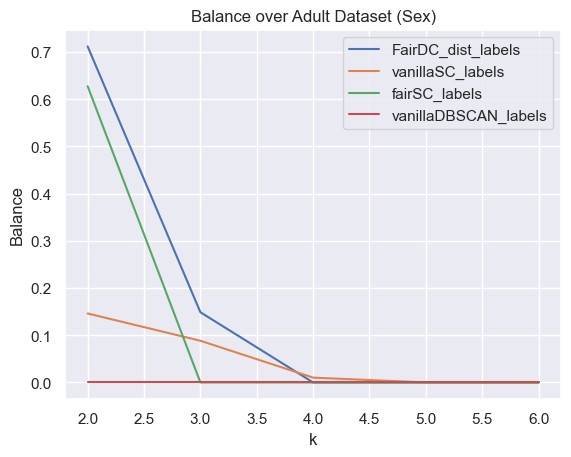

In [84]:
ks = list(range(2, 7))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, balance_list_adult_sex[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, balance_list_adult_sex[1], label = "vanillaSC_labels")
plt.plot(ks, balance_list_adult_sex[2], label = "fairSC_labels")
plt.plot(ks, balance_list_adult_sex[3], label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Balance over Adult Dataset (Sex)")
plt.ylabel("Balance")
plt.xlabel("k")
plt.show()

# add silhouette coefficient to it

In [82]:
silhouette_list_adult_sex = silhouette_over_all_k(data_adult, sex, 7, adjacency_adult_sex_standardized, 
                            min_points = 5, n_neighbors = 10, eps =  1.2, min_pts = 5)


rank:  1
(902, 902)
(902, 2)
rank:  1
(902, 901)
(902, 901)
(902, 902)
rank:  1
(902, 902)
(902, 3)
rank:  1
(902, 901)
(902, 901)
(902, 902)
rank:  1
(902, 902)
(902, 4)
rank:  1
(902, 901)
(902, 901)
(902, 902)
rank:  1
(902, 902)
(902, 5)
rank:  1
(902, 901)
(902, 901)
(902, 902)
rank:  1
(902, 902)
(902, 6)
rank:  1
(902, 901)
(902, 901)
(902, 902)


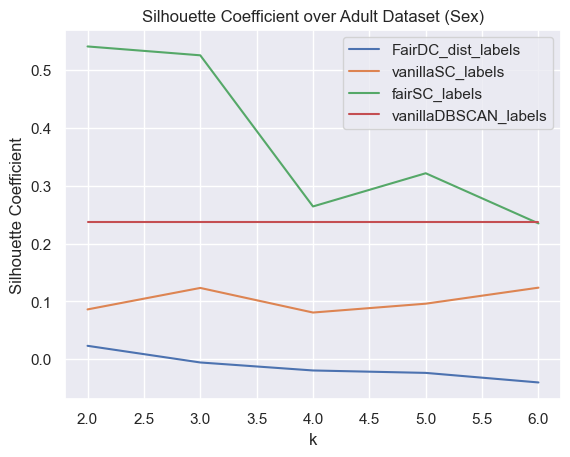

In [85]:
ks = list(range(2, 7))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, silhouette_list_adult_sex[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, silhouette_list_adult_sex[1], label = "vanillaSC_labels")
plt.plot(ks, silhouette_list_adult_sex[2], label = "fairSC_labels")
plt.plot(ks, silhouette_list_adult_sex[3], label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Silhouette Coefficient over Adult Dataset (Sex)")
plt.ylabel("Silhouette Coefficient")
plt.xlabel("k")
plt.show()


In [118]:
# Define the range of epsilon values
# epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
start = 0.6
stop = 1.7
num_points = 20

# Generate an exponential range of epsilon values
epsilon_range = np.logspace(np.log10(start), np.log10(stop), num=num_points)
# epsilon_range = np.linspace(0.1, 2.1, num = num_points)

# Loop over each epsilon value
for epsilon in epsilon_range:    
    dbscan = DBSCAN(eps = epsilon, min_pts = 5, cluster_type = 'standard')
    dbscan.fit(data_adult)
    labels = dbscan.labels_
    
    # Count the number of clusters (excluding noise points)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(np.unique(labels))
    num_clusters2 = len(np.unique(labels))
    
    # Calculate the silhouette score
    
    # Print the results
    print("Epsilon:", epsilon)
    print("Number of clusters:", num_clusters)
    print()
    
eps_list = [1.2235397352309134, 1.1582783461019526,  1.096497881039784, 0.9826469615208944, 0.8336468123019314]
# put these on graph, remember star in overleaf

[-1.  1.  2.  3.  4.  5.  6.  7.  8.]
Epsilon: 0.6
Number of clusters: 8

[-1.  1.  2.  3.  4.  5.  6.  7.]
Epsilon: 0.633806065363437
Number of clusters: 7

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 0.6695168808191356
Number of clusters: 6

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 0.7072397665439627
Number of clusters: 6

[-1.  1.  2.  3.  4.  5.  6.  7.  8.]
Epsilon: 0.7470880895029746
Number of clusters: 8

[-1.  1.  2.  3.  4.  5.  6.  7.  8.]
Epsilon: 0.7891816041462794
Number of clusters: 8

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 0.8336468123019314
Number of clusters: 6

[-1.  1.  2.  3.  4.  5.]
Epsilon: 0.8806173433464314
Number of clusters: 5

[-1.  1.  2.  3.  4.  5.]
Epsilon: 0.930234355795341
Number of clusters: 5

[-1.  1.  2.  3.  4.]
Epsilon: 0.9826469615208944
Number of clusters: 4

[-1.  1.  2.  3.  4.]
Epsilon: 1.0380126738714912
Number of clusters: 4

[-1.  1.  2.  3.  4.]
Epsilon: 1.096497881039784
Number of clusters: 4

[-1.  1.  2.  3.]
Epsilon: 1.1582783461019526
Numb

In [128]:
DBSCAN_balance = []
DBSCAN_sil = []
for epsi in eps_list: 
    dbscan = DBSCAN(eps =epsi, min_pts = 5, cluster_type = 'standard')
    dbscan.fit(data_adult)
    labels = dbscan.labels_
    
    DBSCAN_balance.append(bera_balance(labels, sex))
    DBSCAN_sil.append(silhouette_score(data_adult, labels))
    
# if we want to remove outliers

overall indi merged 
    overall    c0     c1    c2
G                            
0      608  66.0  529.0  13.0
1      294  23.0  271.0   0.0
r_c0    0.792861
r_c1    0.962191
r_c2    0.000000
dtype: float64
overall indi merged 
    overall    c0     c1   c2   c3
G                                
0      608  77.0  516.0  9.0  6.0
1      294  27.0  267.0  0.0  0.0
r_c0    0.796507
r_c1    0.955853
r_c2    0.000000
r_c3    0.000000
dtype: float64


C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


overall indi merged 
    overall    c0     c1   c2   c3   c4
G                                     
0      608  88.0  509.0  5.0  6.0  0.0
1      294  35.0  252.0  0.0  0.0  7.0
r_c0    0.873016
r_c1    0.984294
r_c2    0.000000
r_c3    0.000000
r_c4    0.000000
dtype: float64
overall indi merged 
    overall     c0     c1   c2     c3   c4
G                                        
0      608  107.0  496.0  5.0    0.0  0.0
1      294   47.0    0.0  0.0  240.0  7.0
r_c0    0.936346
r_c1    0.000000
r_c2    0.000000
r_c3    0.000000
r_c4    0.000000
dtype: float64
overall indi merged 
    overall     c0     c1   c2   c3   c4     c5   c6
G                                                  
0      608  151.0  439.0  5.0  8.0  5.0    0.0  0.0
1      294   69.0    0.0  0.0  0.0  0.0  220.0  5.0
r_c0    0.962245
r_c1    0.000000
r_c2    0.000000
r_c3    0.000000
r_c4    0.000000
r_c5    0.000000
r_c6    0.000000
dtype: float64


C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


In [126]:
DBSCAN_balance

[0.0, 0.0, 0.0, 0.0, 0.0]

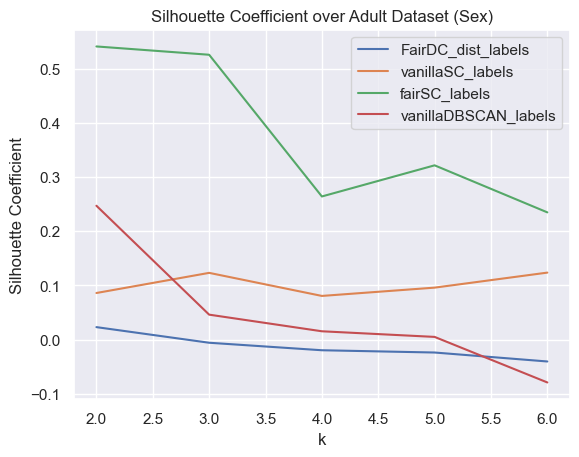

In [124]:
ks = list(range(2, 7))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, silhouette_list_adult_sex[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, silhouette_list_adult_sex[1], label = "vanillaSC_labels")
plt.plot(ks, silhouette_list_adult_sex[2], label = "fairSC_labels")
plt.plot(ks, DBSCAN_sil, label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Silhouette Coefficient over Adult Dataset (Sex)")
plt.ylabel("Silhouette Coefficient")
plt.xlabel("k")
plt.show()

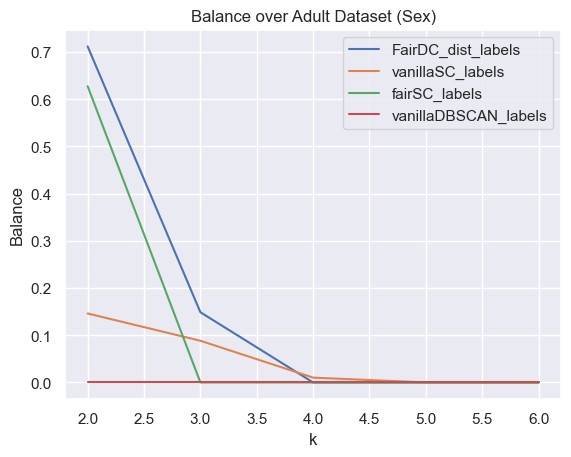

In [125]:
plt.plot(ks, balance_list_adult_sex[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, balance_list_adult_sex[1], label = "vanillaSC_labels")
plt.plot(ks, balance_list_adult_sex[2], label = "fairSC_labels")
plt.plot(ks, DBSCAN_balance, label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Balance over Adult Dataset (Sex)")
plt.ylabel("Balance")
plt.xlabel("k")
plt.show()

In [108]:
DBSCAN_balance = []
# for eps in eps_list:
dbscan = DBSCAN(eps =3, min_pts = 5, cluster_type = 'standard')
dbscan.fit(data_adult)
labels = dbscan.labels_

# join with dataset
cluster_predict = labels.reshape(-1, 1)
# Concatenate the new column to the matrix
data_adult1 = np.concatenate((data_adult, cluster_predict), axis=1)
print(data_adult1[:2])
df_adult = pd.DataFrame(data_adult1)
# print(df_adult)
count = df_adult.groupby(6).size()
print("count", count)
# remove outliers
# data_adult1 = df_adult[df_adult[7] != -1]

# count = data_adult1.groupby('7').count()
print(bera_balance(labels, sex))

    
    # compute balance
    
    # append bal to list
    
    # remove the smaller clusters

[[-0.82513127  1.12893436  1.1311998  -0.34768974 -0.23722079 -0.07928454
   1.        ]
 [ 0.76302634  0.0194706   1.52500228 -0.34768974 -0.23722079  0.31979278
   1.        ]]
count 6
-1.0      4
 1.0    898
dtype: int64
overall indi merged 
    overall  c0   c1
G                  
0      608   1  607
1      294   3  291
result 
    overall  c0   c1  r_overall
G                             
0      608   1  607   0.674058
1      294   3  291   0.325942
balance 
        r_c0      r_c1
G                    
0  0.370888  1.002802
1  2.301020  0.994205
balanec inv 
        r_c0      r_c1
G                    
0  2.696231  0.997206
1  0.434590  1.005829
r_c0    0.370888
r_c1    0.994205
dtype: float64
0.37088815789473684


In [ ]:
print(bera_balance(labels, sex))

In [ ]:
labels_list = labels_for_specific_k(data_adult, sex, 2, adjacency_adult_sex, 
                            min_points = 5, n_neighbors = 10, eps =  1.2, min_pts = 5)

# exponential epsilon for DBSCAN

In [ ]:
a = [np.unique(i, return_counts = True) for i in labels_list]
a

In [ ]:
# data_adult
labels = labels_list[2]
ad = np.column_stack((data_adult, labels))

In [ ]:
ad_df = pd.DataFrame(ad)
display(ad_df.head())

In [ ]:
filtered_rows = ad_df[ad_df[6] == 1]
print(filtered_rows)
print("here")
# print(ad_df[ad_df[4] == 99999])
# print(ad_df[ad_df[1] == 749636])
print(ad_df.min())
print(ad_df.max())
print(ad_df.mean())


In [ ]:
display(adult_sample_sex_dropy.head())
labels = labels_list[2]

# Add the list as a new column to the DataFrame
adult_sample_sex_dropy['labels'] = labels
print(adult_sample_sex_dropy)

In [ ]:
filtered_rows = adult_sample_sex_dropy[adult_sample_sex_dropy['labels'] == 1]
print(filtered_rows)
print(adult_sample_sex_dropy[adult_sample_sex_dropy['capital-gain'] == 99999])
print(adult_sample_sex_dropy[adult_sample_sex_dropy['fnlwgt'] == 749636])
print(adult_sample_sex_dropy.min())
print(adult_sample_sex_dropy.max())

In [ ]:
bera_balance(labels_list[2], sex)

### Adult (Race)

In [ ]:
print(adult_df['race'].value_counts())

In [ ]:
# chierichetti euclidean space - age, fnlwgt, education-num, capital-gain, hours-per week, balance gender
# chierichetti: numeric attributes to rep. euclidean space: age, balance, duration - cluster to balance married and not marrided
adult_columns_to_remove_race = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'capital-loss']
adult_train_filtered_race = adult_df.drop(columns=adult_columns_to_remove_race)

In [ ]:
display(adult_train_filtered_race.head())
display(adult_train_filtered_race.shape)

In [ ]:
# one hot encoding salary
adult_train_filtered_race['salary'] = adult_train_filtered_race['salary'].replace({'<=50K': 0, '>50K': 1})

# encoding race like in https://github.com/nicolasjulioflores/fair_algorithms_for_clustering/blob/master/config/dataset_configs.ini
#lambda x : x == 0, lambda x : x == 1, lambda x : x == 2, lambda x : x == 3, lambda x : x == 4

adult_train_filtered_race['race'] = adult_train_filtered_race['race'].replace({'White': 0, 'Black': 1, 'Asian-Pac-Islander': 2, 
                                                                     'Amer-Indian-Eskimo': 3, 'Other': 4})

In [ ]:
# subsampling to 600 with chierichetti
adult_sample_race = adult_train_filtered_race.sample(n=600, random_state=42)

In [ ]:
# standard normalization
scaler = StandardScaler()
adult_y = adult_sample_race['salary'].to_numpy()
race = adult_sample_race['race'].to_numpy()
# Fit the scaler on the specified columns
adult_sample_race = adult_sample_race.drop(columns=['salary'])

adult_normalized_race = scaler.fit_transform(adult_sample_race)  # removed y

In [ ]:
# adjacency for kleindesser
adjacency_adult_race = generate_adjacency_Gaussian(adult_normalized_race)

In [ ]:
balance_list_adult_race = balance_list_over_all_k(adult_normalized_race, race, 7, adjacency_adult_race, 
                            min_points = 5, n_neighbors = 10, eps =  1.2, min_pts = 2)

In [ ]:
balance_list_adult_race

In [ ]:
ks = list(range(2, 7))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, balance_list_adult_sex[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, balance_list_adult_sex[1], label = "vanillaSC_labels")
plt.plot(ks, balance_list_adult_sex[2], label = "fairSC_labels")
plt.plot(ks, balance_list_adult_sex[3], label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Adult Dataset (Race)")
plt.show()

## Bank-Marketing

### Bank-Marketing (Marital-Status)

In [153]:
# loading dataset
bank_filepath = 'data/bank-full.csv'

bank_df = pd.read_csv(bank_filepath, sep = ';')

In [154]:
display(bank_df.head())
display(bank_df.shape)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


(45211, 17)

In [155]:
# removing missing values
# remove missing values and day-month columns
bank_df.dropna(axis = 0, inplace = True)
display(bank_df.shape)

(45211, 17)

In [156]:
print(bank_df['marital'].value_counts())

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


In [157]:
# chierichetti: numeric attributes to rep. euclidean space: age, balance, duration - cluster to balance married and not marrided
columns_to_remove = ['day', 'month', 'contact', 'pdays', 'campaign', 'previous', 'poutcome', 'job', 'education', 'default', 'housing', 'loan']
# default is also sensitive value
bank_df_filtered = bank_df.drop(columns=columns_to_remove)

In [158]:
display(bank_df_filtered.head())
display(bank_df_filtered.shape)

,age,marital,balance,duration,y
0,58,married,2143,261,no
1,44,single,29,151,no
2,33,married,2,76,no
3,47,married,1506,92,no
4,33,single,1,198,no


(45211, 5)

In [159]:
bank_df_filtered['y'] = bank_df_filtered['y'].replace({'no': 0, 'yes': 1})

In [160]:
display(bank_df_filtered.head())

,age,marital,balance,duration,y
0,58,married,2143,261,0
1,44,single,29,151,0
2,33,married,2,76,0
3,47,married,1506,92,0
4,33,single,1,198,0


In [161]:
# subsampling 

bank_att_ratio = bank_df_filtered['marital'].value_counts(normalize = True)
print(bank_att_ratio)

subset_data_bank = bank_df_filtered.groupby('marital', group_keys = False).apply(lambda x: x.sample(frac = 0.01))
subset_ratio_bank = subset_data_bank['marital'].value_counts(normalize = True)
print(len(subset_data_bank))

print(subset_ratio_bank)
# need to proportionality - that it's realistic compared to OG dataset

married     0.601933
single      0.282896
divorced    0.115171
Name: marital, dtype: float64
452
married     0.601770
single      0.283186
divorced    0.115044
Name: marital, dtype: float64


In [162]:
# bank_df_filtered['marital'] = bank_df_filtered['marital'].replace({'single': 0, 'divorced': 1, 'married': 2})

# one-hot encoded marital, remove ordinal marital encoding

bank_encoded = pd.get_dummies(subset_data_bank['marital'])

# Concatenate the encoded DataFrame with the original DataFrame
bank_encoded = pd.concat([subset_data_bank, bank_encoded], axis=1)

marital = bank_encoded['marital'].to_frame()

# Remove the original categorical attribute from the DataFrame
bank_encoded.drop('marital', axis=1, inplace=True)

display(bank_encoded.head())
display(marital.head())

,age,balance,duration,y,divorced,married,single
11944,48,2677,23,0,1,0,0
36640,54,1012,33,0,1,0,0
3276,46,1480,257,0,1,0,0
21857,42,0,155,0,1,0,0
26156,51,2011,118,0,1,0,0


,marital
11944,divorced
36640,divorced
3276,divorced
21857,divorced
26156,divorced


In [163]:
bank_encoded['divorced'] = bank_encoded['divorced'].replace({0: 0, 1: 1})
bank_encoded['married'] = bank_encoded['married'].replace({0: 0, 1: 1})
bank_encoded['single'] = bank_encoded['single'].replace({0: 0, 1: 1})

In [164]:
display(bank_encoded.head())

,age,balance,duration,y,divorced,married,single
11944,48,2677,23,0,1,0,0
36640,54,1012,33,0,1,0,0
3276,46,1480,257,0,1,0,0
21857,42,0,155,0,1,0,0
26156,51,2011,118,0,1,0,0


In [165]:
# code marital into 1,2,3
marital['marital'] = marital['marital'].replace({'single': 0, 'divorced': 1, 'married': 2})
display(marital.head())

,marital
11944,1
36640,1
3276,1
21857,1
26156,1


In [204]:
scaler = StandardScaler()

bank_y = bank_encoded['y'].to_numpy()
marital_sens = marital.to_numpy().flatten()

bank_sample_dropy = bank_encoded.drop(columns = ['y', 'divorced', 'married', 'single'])
display(bank_sample_dropy.head())

bank_standardized = scaler.fit_transform(bank_sample_dropy)
print(bank_standardized[:10])

,age,balance,duration
11944,48,2677,23
36640,54,1012,33
3276,46,1480,257
21857,42,0,155
26156,51,2011,118


[[ 0.73908547  0.31707582 -0.99797358]
 [ 1.32007092 -0.0984183  -0.95516242]
 [ 0.54542366  0.01836924  0.00380754]
 [ 0.15810002 -0.35095887 -0.43286628]
 [ 1.0295782   0.15087817 -0.59126757]
 [-0.90703997 -0.6466709  -0.74966886]
 [ 1.1264091  -0.11538743 -0.58698645]
 [-0.81020906 -0.35470206 -0.53133195]
 [ 0.15810002 -0.29705693 -0.47995856]
 [ 1.90105637 -0.18550986  0.55179038]]


In [206]:
# adjacency for kleindesser
adjacency_bank = generate_adjacency_Gaussian(bank_standardized)
adjacency_bank_standardized = scaler.fit_transform(adjacency_bank)

In [207]:
spectral_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
bank_vanillaSC_labels = spectral_model.fit_predict(bank_standardized)
bera_balance(bank_vanillaSC_labels, marital_sens)

overall indi merged 
    overall   c0   c1
G                   
0      128   34   94
1       52   39   13
2      272  161  111
r_c0    0.513088
r_c1    0.518349
dtype: float64


0.5130876068376069

In [208]:
balance_list_bank = balance_list_over_all_k(bank_standardized, marital_sens, 7, adjacency_bank_standardized, min_points = 5, n_neighbors = 10,
                                           eps = 1.8, min_pts = 5)

rank:  2
(452, 452)
(452, 2)
rank:  2
(452, 450)
(452, 450)
(452, 452)
overall indi merged 
    overall  c0   c1
G                  
0      128  35   93
1       52  15   37
2      272  69  203
r_c0    0.912684
r_c1    0.965812
dtype: float64
overall indi merged 
    overall   c0   c1
G                   
0      128   34   94
1       52   39   13
2      272  161  111
r_c0    0.513088
r_c1    0.518349
dtype: float64
overall indi merged 
    overall     c0   c1
G                     
0      128  128.0  0.0
1       52   52.0  0.0
2      272  269.0  3.0
r_c0    0.993363
r_c1    0.000000
dtype: float64
overall indi merged 
    overall   c0     c1
G                     
0      128  0.0  128.0
1       52  0.0   52.0
2      272  6.0  266.0
r_c0    0.000000
r_c1    0.986726
dtype: float64


C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  2
(452, 452)
(452, 3)
rank:  2
(452, 450)
(452, 450)
(452, 452)
overall indi merged 
    overall   c0  c1  c2
G                      
0      128   75  46   7
1       52   31  20   1
2      272  164  84  24
r_c0    0.980903
r_c1    0.862832
r_c2    0.271635
dtype: float64
overall indi merged 
    overall  c0   c1  c2
G                      
0      128  79   15  34
1       52  11   29  12
2      272  98  121  53
r_c0    0.508592
r_c1    0.321023
r_c2    0.824571
dtype: float64
overall indi merged 
    overall     c0   c1   c2
G                          
0      128  128.0  0.0  0.0
1       52   51.0  0.0  1.0
2      272  268.0  1.0  3.0
r_c0    0.988938
r_c1    0.000000
r_c2    0.000000
dtype: float64
overall indi merged 
    overall   c0     c1
G                     
0      128  0.0  128.0
1       52  0.0   52.0
2      272  6.0  266.0
r_c0    0.000000
r_c1    0.986726
dtype: float64


C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  2
(452, 452)
(452, 4)
rank:  2
(452, 450)
(452, 450)
(452, 452)
overall indi merged 
    overall   c0  c1  c2  c3
G                          
0      128   71  38  13   6
1       52   29  11  11   1
2      272  153  70  25  24
r_c0    0.990983
r_c1    0.803491
r_c2    0.512470
r_c3    0.280397
dtype: float64
overall indi merged 
    overall  c0   c1  c2  c3
G                          
0      128  32   35  11  50
1       52   8   19  22   3
2      272  50  112  81  29
r_c0    0.772650
r_c1    0.744541
r_c2    0.340735
r_c3    0.318011
dtype: float64
overall indi merged 
    overall     c0   c1   c2   c3
G                               
0      128  126.0  0.0  2.0  0.0
1       52   51.0  0.0  1.0  0.0
2      272  263.0  1.0  7.0  1.0
r_c0    0.988903
r_c1    0.000000
r_c2    0.706250
r_c3    0.000000
dtype: float64
overall indi merged 
    overall   c0     c1
G                     
0      128  0.0  128.0
1       52  0.0   52.0
2      272  6.0  266.0
r_c0    0.000000
r_c1    0.98672

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  2
(452, 452)
(452, 5)
rank:  2
(452, 450)
(452, 450)
(452, 452)
overall indi merged 
    overall  c0  c1  c2  c3  c4
G                             
0      128  24  16  49  33   6
1       52  14  11  15  11   1
2      272  64  29  92  65  22
r_c0    0.830882
r_c1    0.585680
r_c2    0.835799
r_c3    0.877205
r_c4    0.299735
dtype: float64
overall indi merged 
    overall  c0  c1  c2  c3  c4
G                             
0      128  44  16  11  43  14
1       52   4  15  21   3   9
2      272  69  63  87  23  30
r_c0    0.297173
r_c1    0.601064
r_c2    0.326418
r_c3    0.377926
r_c4    0.677483
dtype: float64
overall indi merged 
    overall     c0   c1   c2   c3   c4
G                                    
0      128  127.0  1.0  0.0  0.0  0.0
1       52   51.0  0.0  0.0  1.0  0.0
2      272  266.0  1.0  1.0  3.0  1.0
r_c0    0.990036
r_c1    0.000000
r_c2    0.000000
r_c3    0.000000
r_c4    0.000000
dtype: float64
overall indi merged 
    overall   c0     c1
G                 

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  2
(452, 452)
(452, 6)
rank:  2
(452, 450)
(452, 450)
(452, 452)
overall indi merged 
    overall  c0  c1  c2  c3  c4  c5
G                                 
0      128  26  22  48   7  12  13
1       52  11  13  14   1  11   2
2      272  49  61  92  25  24  21
r_c0    0.899437
r_c1    0.809245
r_c2    0.790210
r_c3    0.263403
r_c4    0.491553
r_c5    0.482906
dtype: float64
overall indi merged 
    overall  c0  c1  c2  c3  c4  c5
G                                 
0      128  34  45   7  14  20   8
1       52   3   4  12   6   5  22
2      272  14  77  35  29  31  86
r_c0    0.424779
r_c1    0.275946
r_c2    0.457755
r_c3    0.939528
r_c4    0.776099
r_c5    0.243534
dtype: float64
overall indi merged 
    overall     c0   c1   c2   c3   c4   c5
G                                         
0      128  127.0  0.0  0.0  0.0  0.0  1.0
1       52   51.0  0.0  0.0  1.0  0.0  0.0
2      272  266.0  1.0  1.0  2.0  1.0  1.0
r_c0    0.990036
r_c1    0.000000
r_c2    0.000000
r_c3    0.000

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_6920\224395815.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


In [209]:
balance_list_bank

([0.912684365781711,
  0.27163461538461536,
  0.2803970223325062,
  0.29973474801061006,
  0.2634032634032634],
 [0.5130876068376069,
  0.3210227272727273,
  0.31801125703564725,
  0.297172912557528,
  0.2435344827586207],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0])

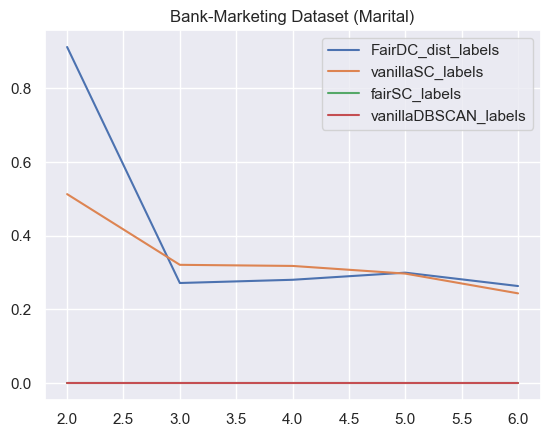

In [210]:
ks = list(range(2, 7))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, balance_list_bank[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, balance_list_bank[1], label = "vanillaSC_labels")
plt.plot(ks, balance_list_bank[2], label = "fairSC_labels")
plt.plot(ks, balance_list_bank[3], label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Bank-Marketing Dataset (Marital)")
plt.show()

In [ ]:
eps_list = [3.055689903065826, 1.9574338205844326,  1.0475268015357952, 0.7663094323935532, 0.29999999999999993]
bank_DBSCAN_balance = []
bank_DBSCAN_sil = []
for epsi in eps_list: 
    dbscan = DBSCAN(eps =epsi, min_pts = 5, cluster_type = 'standard')
    dbscan.fit(data_adult)
    labels = dbscan.labels_
    
    bank_DBSCAN_balance.append(bera_balance(labels, sex))
    bank_DBSCAN_sil.append(silhouette_score(data_adult, labels))
    
# if we want to remove outliers

In [ ]:

ks = list(range(2, 7))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, silhouette_list_adult_sex[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, silhouette_list_adult_sex[1], label = "vanillaSC_labels")
plt.plot(ks, silhouette_list_adult_sex[2], label = "fairSC_labels")
plt.plot(ks, DBSCAN_sil, label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Silhouette Coefficient over Adult Dataset (Sex)")
plt.ylabel("Silhouette Coefficient")
plt.xlabel("k")
plt.show()

In [ ]:
labels_list = labels_for_specific_k(bank_standardized, marital, 2, adjacency_bank_standardized, 
                            min_points = 5, n_neighbors = 10, eps =  3, min_pts = 5)

In [ ]:
cluster_predict = labels_list[1].reshape(-1, 1)
# Concatenate the new column to the matrix
data_bank1 = np.concatenate((bank_standardized, cluster_predict), axis=1)
df_bank = pd.DataFrame(data_bank1)
# print(df_adult)
count = df_bank.groupby(6).size()
print("count", count)

print(bera_balance(cluster_predict.flatten(), marital))

In [183]:
# Define the range of epsilon values
# epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
start = 1.9
stop = 3.5
num_points = 10

# Generate an exponential range of epsilon values
epsilon_range = np.logspace(np.log10(start), np.log10(stop), num=num_points)
# epsilon_range = np.linspace(0.1, 2.1, num = num_points)

# Loop over each epsilon value
for epsilon in epsilon_range:    
    dbscan = DBSCAN(eps = epsilon, min_pts = 5, cluster_type = 'standard')
    dbscan.fit(bank_standardized)
    bank_labels = dbscan.labels_
    
    # Count the number of clusters (excluding noise points)
    num_clusters = len(set(bank_labels)) - (1 if -1 in labels else 0)
    print(np.unique(labels))
    
    # Calculate the silhouette score
    
    # Print the results
    print("Epsilon:", epsilon)
    print("Number of clusters:", num_clusters)
    print()
    
eps_list = [3.055689903065826, 1.9574338205844326,  1.0475268015357952, 0.7663094323935532, 0.29999999999999993]
# put these on graph, remember star in overleaf


[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 1.9
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 2.0334475907349594
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 2.1762679496135853
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 2.3291193783870816
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 2.4927064150080622
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 2.667783081056696
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 2.855156357251698
Number of clusters: 3

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 3.055689903065826
Number of clusters: 2

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 3.2703080375907088
Number of clusters: 2

[-1.  1.  2.  3.  4.  5.  6.]
Epsilon: 3.5000000000000004
Number of clusters: 2



In [142]:
# dunno what this is for
# start over, get the bank
scaler = StandardScaler()
bank_y = bank_encoded['y'].to_numpy()
# marital = subset_data_bank['marital'].to_numpy()

bank_sample_dropy = bank_encoded.drop(columns = ['y'])

bank_standardized = scaler.fit_transform(bank_sample_dropy)
bank_encoded_numpy = bank_encoded.to_numpy()
# print(bank_encoded_numpy)
bank_standardized[:, :3] = bank_encoded_numpy[:, :3]
# bank_standardized[['divorced', 'married', 'single']] = bank_encoded[['divorced', 'married', 'single']]

subset_columns = ['age', 'balance', 'duration']  # Example: Columns 'column1', 'column2', and 'column3'

# Extract the subset of columns from the DataFrame
subset = bank_sample_dropy[subset_columns]

# Fit and transform the subset of data
subset_standardized = scaler.fit_transform(subset)
bank_standardized = pd.DataFrame(subset_standardized, columns=subset_columns)
# print(subset_standardized)
# bank_sample_dropy[subset_columns] = bank_standardized


bank_sample_dropy = bank_sample_dropy.drop(columns = subset_columns)
bank_sample_dropy = pd.concat(bank_sample_dropy, bank_standardized)
# print(bank_sample_dropy[:10])

# bank_sample_dropy = bank_sample_dropy.insert(3, 'age', bank_standardized['age'])

# # # Create a new DataFrame with the standardized values
# bank_standardized = pd.DataFrame(subset_standardized, columns=subset_columns)
# print(bank_standardized[:5])
# print(bank_sample_dropy)
# # Replace the original subset with the standardized values

# bank_sample_dropy[subset_columns] = bank_standardized

# col age	marital	balance	duration	
display(bank_sample_dropy.head())

C:\Users\annek\AppData\Local\Temp\ipykernel_6920\3673295865.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  bank_sample_dropy = pd.concat(bank_sample_dropy, bank_standardized)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"